# Intelligent Offloading for GenAI Clusters
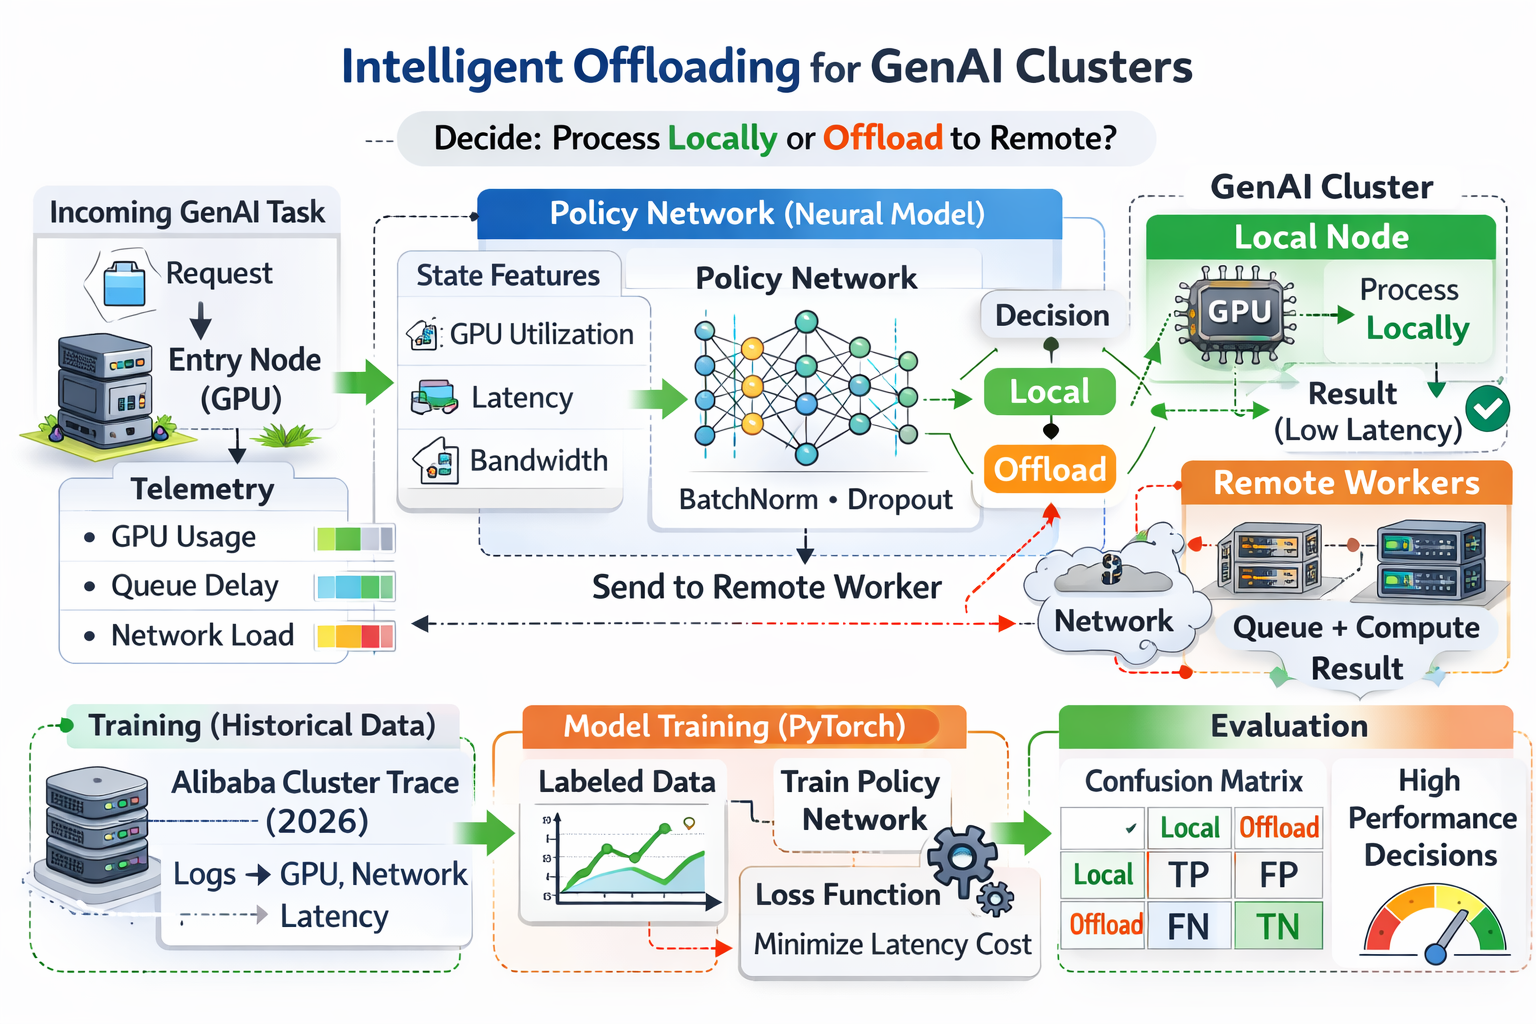
This tutorial demonstrates how to build a neural "Policy Network" using real-world cluster trace data from Alibaba. The goal is to decide whether a GenAI inference task should be processed **Locally** or **Offloaded** to a remote worker based on network congestion and GPU availability.


### Learning Objectives

Upon completion of this notebook, you will be able to:

* **Articulate the challenges** of managing Generative AI workloads in distributed environments, specifically focusing on the trade-offs between local GPU utilization and network-induced latency.
* **Ingest and process real-world telemetry** from the Alibaba GenAI Cluster Trace (2026) to handle authentic production logs.
* **Implement a balanced labeling strategy** using median-based cost scores to solve the "class imbalance" problem inherent in cluster scheduling data.
* **Construct and train a Policy Network** in PyTorch that utilizes BatchNorm and Dropout to reliably predict optimal task placement (Local vs. Offload).
* **Critically evaluate system performance** using confusion matrices and classification reports to interpret how neural decisions impact cluster stability and SLA adherence.

---

### What is Intelligent Offloading?

Intelligent Offloading is a dynamic decision-making process that determines the optimal execution venue for AI inference tasks. In a GenAI cluster, tasks can either be processed on the **Local Node** (the entry point) or **Offloaded** to a remote worker via the network.

The "Intelligent" component refers to using a trained model to analyze live telemetry—such as GPU duty cycles and queuing delays—to predict which path will result in the lowest total latency. This workshop focuses on building a **Policy Network** that bridges the gap between raw hardware metrics and high-level scheduling decisions.

This workshop focuses on neural-based offloading, which offers:

* **Maximized Resource Throughput:** Prevents local GPU stalls by redirecting overflows to idle remote workers.
* **Latency Mitigation:** Proactively avoids network "bottlenecks" by calculating the cost of communication versus the speed of local computation.
* **Real-Time Adaptability:** Allows the infrastructure to react to bursty GenAI traffic patterns that static, rule-based schedulers often miss.
* **Production Reliability:** Leverages actual Alibaba cluster traces to ensure the model reflects real-world hardware behavior and network jitter.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

## 1. Data Acquisition & Pipeline

Modern AI clusters generate massive logs. We begin by fetching three key telemetry streams:

* **Inference Latency:** Time taken for the actual model computation.
* **Queue Response Time:** Delay caused by pending tasks in the network buffer.
* **GPU Duty Cycle:** Current utilization level of the local hardware.

## 2. Balanced Dataset Engineering

A common pitfall in AI infrastructure is "imbalanced labeling" (e.g., the system offloads 99% of the time). We implement a **Median-Based Cost Score** to ensure the model learns a balanced decision boundary between efficiency and congestion.

In [2]:
import os
import glob
import subprocess

def fetch_data():
    # Corrected filenames based on your directory listing
    base_url = "https://github.com/alibaba/clusterdata/raw/master/cluster-trace-v2026-GenAI/"
    files = [
        "pipeline_inference_data_anon.tar.gz",
        "queue_rt_raw_anon.tar.gz",
        "pod_gpu_duty_cycle_anon.tar.gz"
    ]

    for f in files:
        if not os.path.exists(f):
            print(f"Downloading {f}...")
            # Using -L to follow redirects if necessary
            subprocess.run(["wget", "-q", "-L", f"{base_url}{f}"], check=True)

        print(f"Extracting {f}...")
        # Extract files. This creates CSVs in the local directory
        subprocess.run(["tar", "-xzf", f], check=True)

    def find_csv(pattern):
        # Finds the csv even if nested in a subdirectory after extraction
        results = glob.glob(f"**/{pattern}*", recursive=True)
        # Filter for actual .csv files
        csv_results = [r for r in results if r.endswith('.csv')]
        if not csv_results:
            raise FileNotFoundError(f"Could not find a CSV matching {pattern}")
        return csv_results[0]

    # Map the extracted files to their paths
    return (
        find_csv("pipeline_inference_data_anon"),
        find_csv("queue_rt_raw_anon"),
        find_csv("pod_gpu_duty_cycle_anon")
    )

class AlibabaGenAIDataset(Dataset):
    def __init__(self):
        paths = fetch_data()
        data_arrays = []
        for path in paths:
            df = pd.read_csv(path)
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            data_arrays.append(df[numeric_cols[0]].values)

        min_len = min(len(arr) for arr in data_arrays)
        inf_val, queue_val, gpu_val = [arr[:min_len] for arr in data_arrays]

        self.X = np.stack([inf_val, queue_val, gpu_val], axis=1).astype(np.float32)

        # MEDIAN-BASED BALANCED LABELING ---
        # We calculate a relative 'Cost Score'
        # Cost = (Queue Response Time) / (Inference Latency)
        cost_score = queue_val / (inf_val + 1e-6)

        # Label 1 if cost is higher than the average behavior (Congested)
        # Label 0 if cost is lower than average (Efficient)
        threshold = np.median(cost_score)
        self.y = (cost_score > threshold).astype(np.int64)

        print(f"Dataset Balanced: {np.sum(self.y)} Offload vs {len(self.y) - np.sum(self.y)} Local")

        self.scaler = StandardScaler()
        self.X = self.scaler.fit_transform(self.X)

    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

In [3]:
dataset = AlibabaGenAIDataset()
print(f'Total length of the Dataset: { len(dataset)}')
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128)

Extracting pipeline_inference_data_anon.tar.gz...
Extracting queue_rt_raw_anon.tar.gz...
Extracting pod_gpu_duty_cycle_anon.tar.gz...
Dataset Balanced: 11739 Offload vs 11739 Local
Total length of the Dataset: 23478


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def prepare_alibaba_df(dataset_obj):
    """Reverses scaling and returns a clean plotting dataframe."""
    raw_X = dataset_obj.scaler.inverse_transform(dataset_obj.X)
    df = pd.DataFrame(raw_X, columns=['Inf_Latency', 'Queue_RT', 'GPU_Duty_Cycle'])
    df['Label'] = dataset_obj.y
    df['Label_Name'] = df['Label'].map({0: 'Local (Efficient)', 1: 'Offload (Congested)'})
    # Re-calculate cost score for visualization
    df['Cost_Score'] = df['Queue_RT'] / (df['Inf_Latency'] + 1e-6)
    return df

# Initialize the dataframe
df_plot = prepare_alibaba_df(dataset)
sns.set_style("whitegrid")

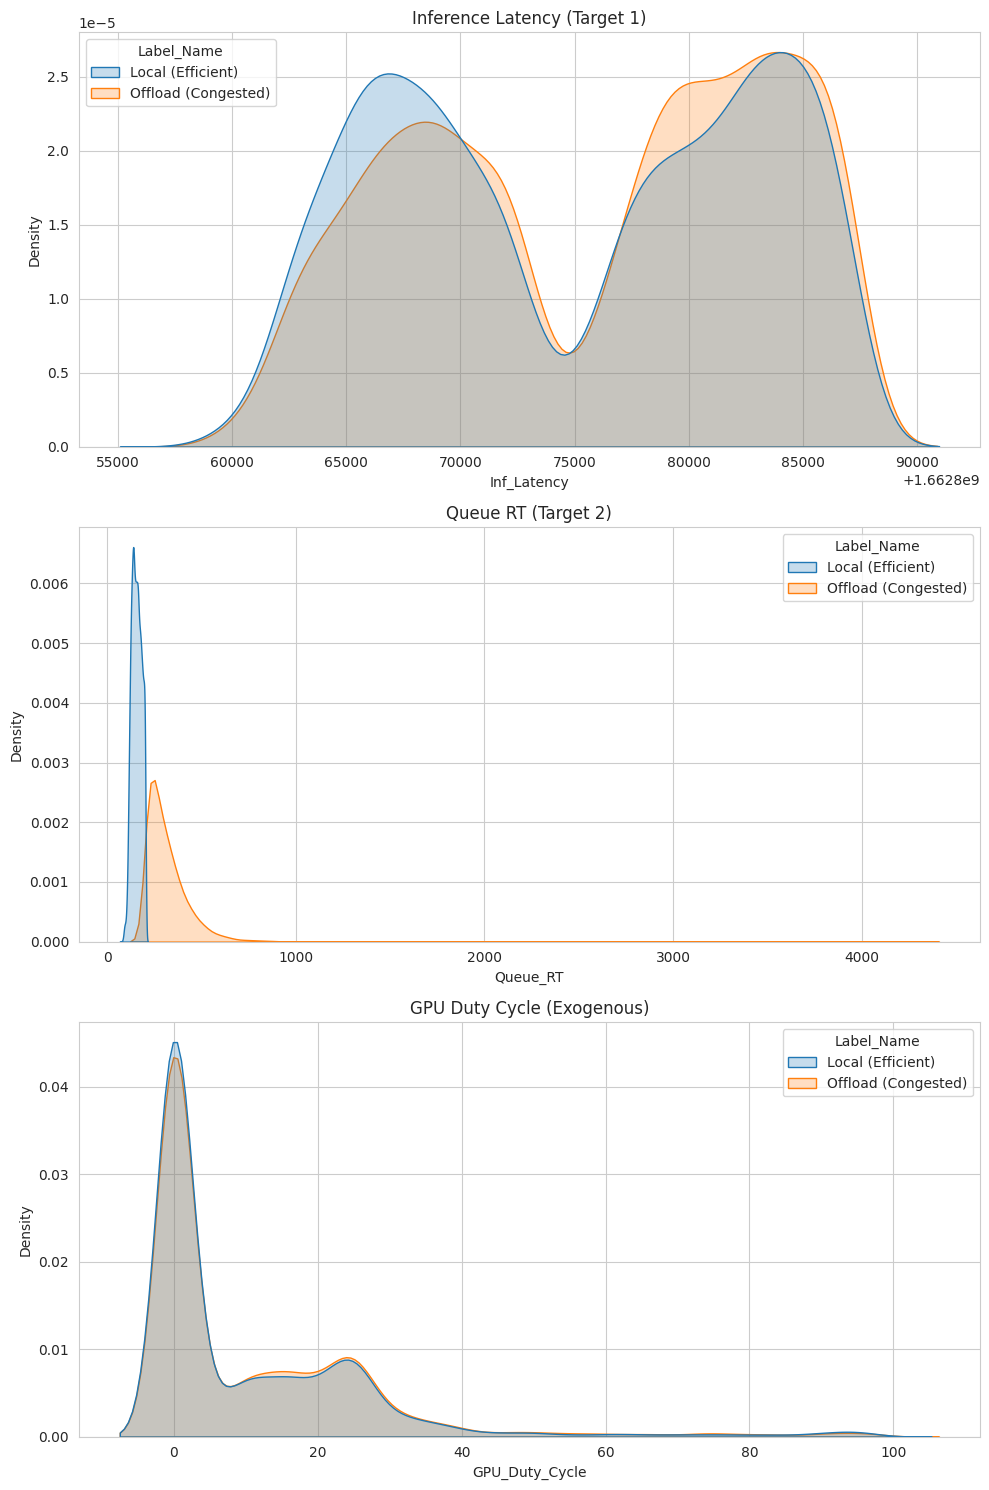

In [6]:
def plot_feature_distributions(df):
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))
    features = ['Inf_Latency', 'Queue_RT', 'GPU_Duty_Cycle']
    titles = ["Inference Latency (Target 1)", "Queue RT (Target 2)", "GPU Duty Cycle (Exogenous)"]

    for i, col in enumerate(features):
        sns.kdeplot(data=df, x=col, hue='Label_Name', fill=True, ax=axes[i])
        axes[i].set_title(titles[i])

    plt.tight_layout()
    plt.show()

plot_feature_distributions(df_plot)

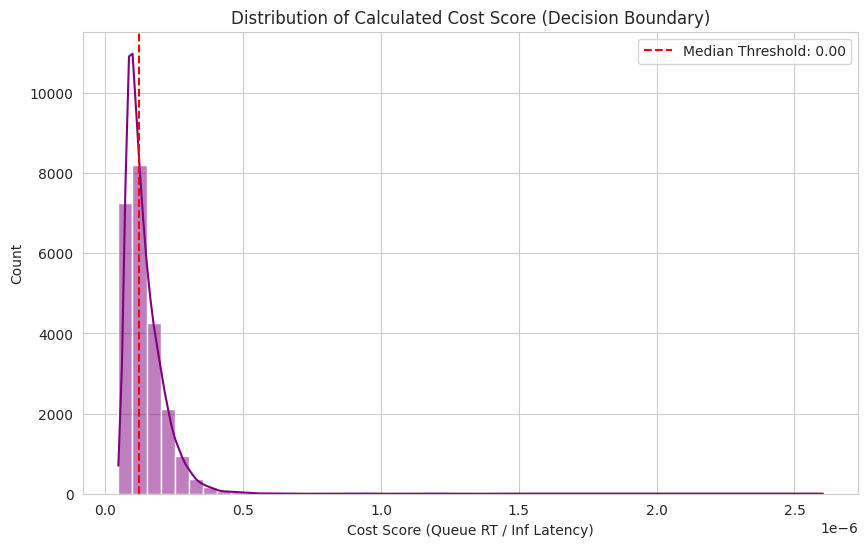

In [7]:
def plot_cost_logic(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Cost_Score'], bins=50, color='purple', kde=True)

    median_val = np.median(df['Cost_Score'])
    plt.axvline(median_val, color='red', linestyle='--',
                label=f'Median Threshold: {median_val:.2f}')

    plt.title("Distribution of Calculated Cost Score (Decision Boundary)")
    plt.xlabel("Cost Score (Queue RT / Inf Latency)")
    plt.legend()
    plt.show()

plot_cost_logic(df_plot)

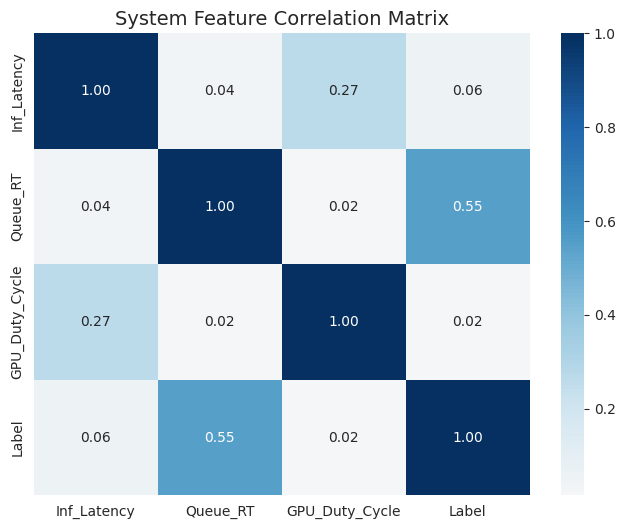

In [10]:
def plot_correlation_matrix(df):
    """Visualizes the linear relationships between system metrics."""
    plt.figure(figsize=(8, 6))

    # Selecting numerical columns relevant to the system state
    cols = ['Inf_Latency', 'Queue_RT', 'GPU_Duty_Cycle', 'Label']
    corr = df[cols].corr()

    sns.heatmap(corr, annot=True, cmap='RdBu', center=0, fmt=".2f")
    plt.title("System Feature Correlation Matrix", fontsize=14)
    plt.show()

# Usage:
plot_correlation_matrix(df_plot)

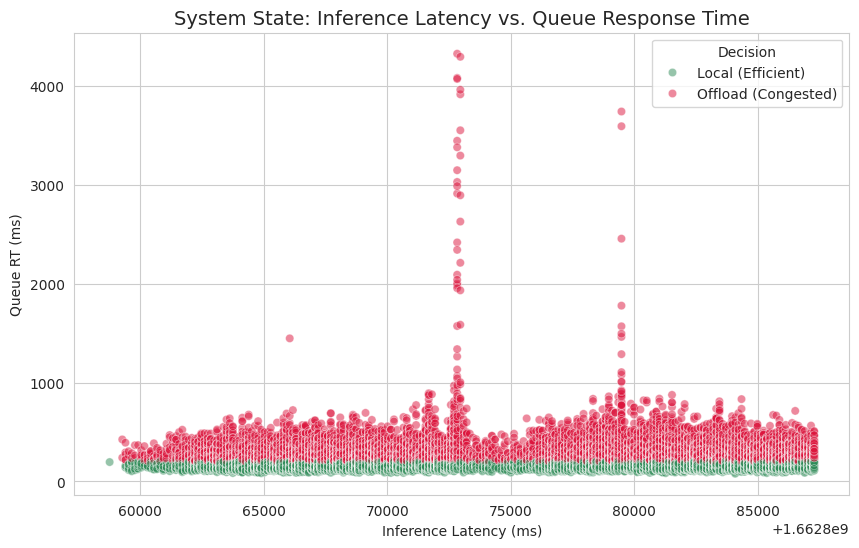

In [11]:
def plot_latency_vs_queue(df):
    """Visualizes the clustering of system states based on performance metrics."""
    plt.figure(figsize=(10, 6))

    sns.scatterplot(
        data=df,
        x='Inf_Latency',
        y='Queue_RT',
        hue='Label_Name',
        alpha=0.5,
        palette={'Local (Efficient)': 'seagreen', 'Offload (Congested)': 'crimson'}
    )

    plt.title("System State: Inference Latency vs. Queue Response Time", fontsize=14)
    plt.xlabel("Inference Latency (ms)")
    plt.ylabel("Queue RT (ms)")
    plt.legend(title="Decision")
    plt.show()

# Usage:
plot_latency_vs_queue(df_plot)

In [9]:
print("="*35)
print("ALIBABA GEN-AI DATASET STATISTICS")
print("="*35)
display(df_plot.groupby('Label_Name')[['Inf_Latency', 'Queue_RT', 'GPU_Duty_Cycle']].mean())
print(f"\nTotal Samples: {len(df_plot):,}")

ALIBABA GEN-AI DATASET STATISTICS


,Inf_Latency,Queue_RT,GPU_Duty_Cycle
Label_Name,,,
Local (Efficient),1.662875e+09,154.602173,10.205333
Offload (Congested),1.662876e+09,321.616119,10.709287



Total Samples: 23,478


## 3. The Policy Network Architecture

The `OffloadingModel` is a deep neural network designed for rapid classification. It uses **Batch Normalization** to handle the varying scales of cluster telemetry and **Dropout** to prevent the model from over-relying on a single metric (like just GPU usage).


In [12]:
class OffloadingModel(nn.Module):
    def __init__(self, input_dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    def forward(self, x): return self.net(x)

## 4. Experimentation & Evaluation

We train the model using **AdamW** (an optimizer that handles weight decay better for deep networks) and evaluate the performance using a **Confusion Matrix**. This helps us see if we are mistakenly offloading tasks that could have been handled faster locally.


Training OffloadingModel...

Training Simple MLP...

FINAL BASELINE COMPARISON
Logistic Regression : 0.9974
Random Forest       : 1.0000
OffloadingModel     : 0.9964
Simple MLP          : 0.9972


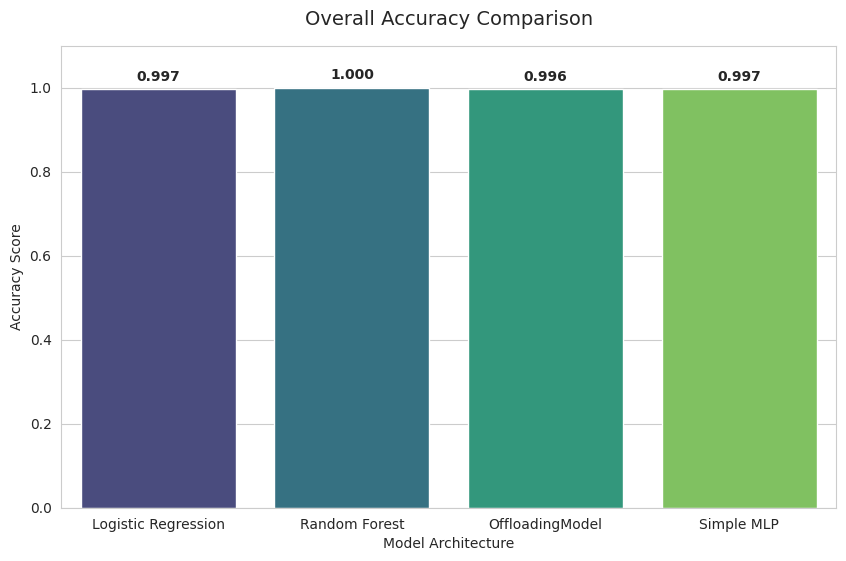

In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Helper to convert DataLoaders to Numpy for Scikit-Learn ---
def loader_to_numpy(loader):
    x_list, y_list = [], []
    for x, y in loader:
        x_list.append(x.numpy())
        y_list.append(y.numpy())
    return np.concatenate(x_list), np.concatenate(y_list)

X_train, y_train = loader_to_numpy(train_loader)
X_test, y_test = loader_to_numpy(test_loader)

# --- 1. Baseline: Logistic Regression ---
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_acc = accuracy_score(y_test, lr_preds)

# --- 2. Baseline: Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)

# --- 3. Baseline: Simple MLP (PyTorch) ---
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )
    def forward(self, x): return self.net(x)

# --- Unified Evaluation Loop Preparation ---
models_to_test = {
    "OffloadingModel": OffloadingModel().to(device),
    "Simple MLP": SimpleMLP().to(device)
}

results = {
    "Logistic Regression": lr_acc,
    "Random Forest": rf_acc
}

final_predictions = {
    "Logistic Regression": lr_preds,
    "Random Forest": rf_preds
}

# --- Training and Eval for PyTorch Models ---
for name, model in models_to_test.items():
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    print(f"\nTraining {name}...")
    for epoch in range(15):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

    model.eval()
    all_preds = []
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(1)
            all_preds.append(preds.cpu().numpy())
            correct += (preds == y).sum().item()
            total += y.size(0)

    results[name] = correct / total
    final_predictions[name] = np.concatenate(all_preds)

# --- Final Comparison Printout ---
print("\n" + "="*30)
print("FINAL BASELINE COMPARISON")
print("="*30)
for name, acc in results.items():
    print(f"{name:20}: {acc:.4f}")

# --- Visualization: Single Column Layout ---
num_models = len(final_predictions)
num_plots = num_models + 1
cols = 1  # Fixed to one column
rows = num_plots

import seaborn as sns
import matplotlib.pyplot as plt

def plot_model_comparison(results_dict):
    """Plots a bar chart comparing accuracy across models."""
    plt.figure(figsize=(10, 6))

    names = list(results_dict.keys())
    values = list(results_dict.values())

    # Create barplot
    ax = sns.barplot(x=names, y=values, palette="viridis", hue=names, legend=False)

    # Formatting
    plt.ylim(0, 1.1)
    plt.title("Overall Accuracy Comparison", fontsize=14, pad=15)
    plt.ylabel("Accuracy Score")
    plt.xlabel("Model Architecture")

    # Add value labels on top of bars
    for i, v in enumerate(values):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

    plt.show()

# Usage:
plot_model_comparison(results)

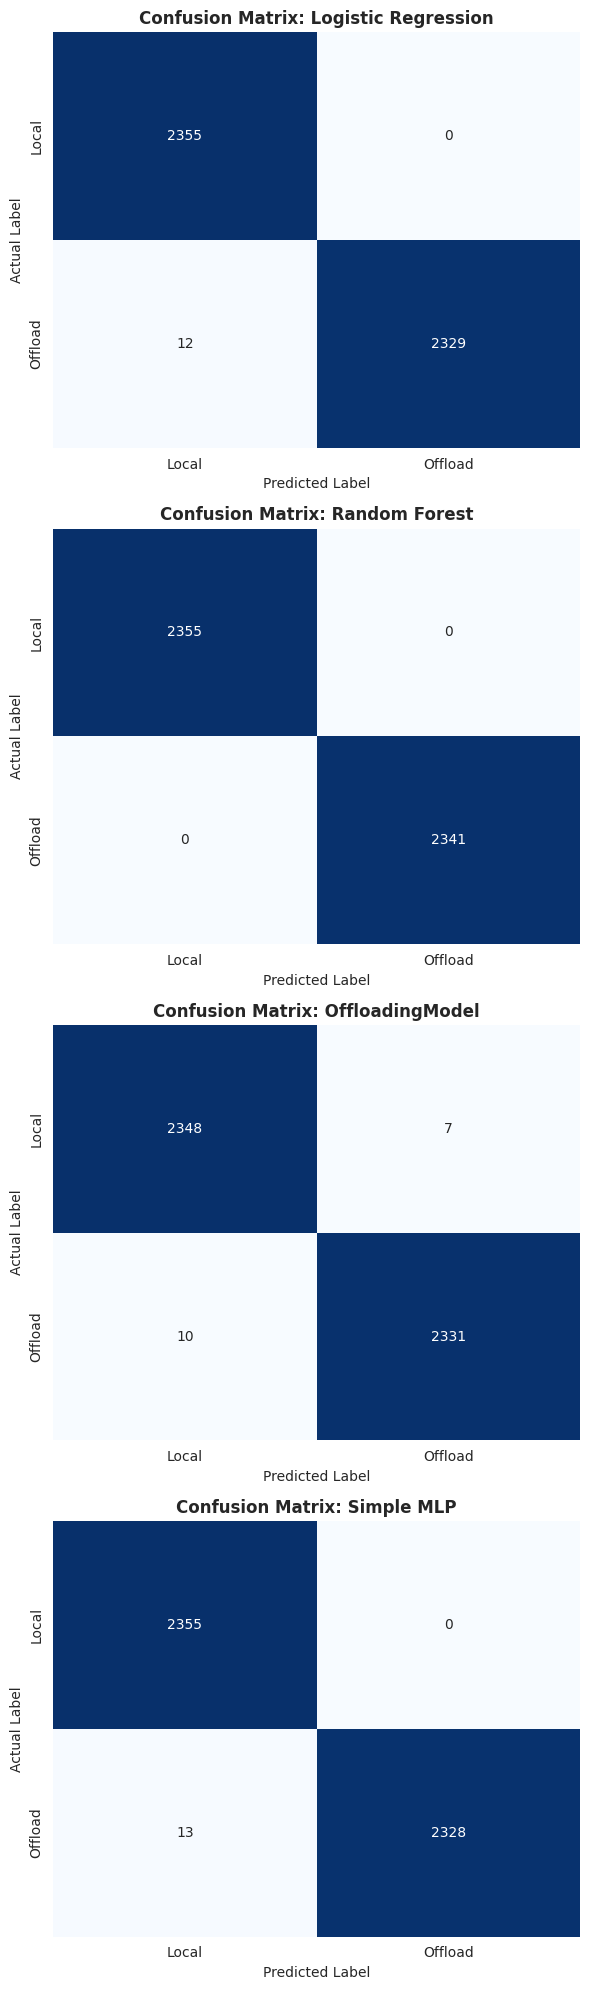

In [14]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices(y_true, predictions_dict):
    """Generates a vertical stack of confusion matrices for each model."""
    num_models = len(predictions_dict)
    fig, axes = plt.subplots(num_models, 1, figsize=(6, 5 * num_models))

    # Handle case where there's only one model (axes won't be a list)
    if num_models == 1:
        axes = [axes]

    for i, (name, preds) in enumerate(predictions_dict.items()):
        cm = confusion_matrix(y_true, preds)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Local', 'Offload'],
                    yticklabels=['Local', 'Offload'],
                    cbar=False, ax=axes[i])

        axes[i].set_title(f"Confusion Matrix: {name}", fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Actual Label')
        axes[i].set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

# Usage:
plot_confusion_matrices(y_test, final_predictions)

In [15]:
from sklearn.metrics import classification_report

for name, preds in final_predictions.items():
    print(f"\n--- {name} Detailed Report ---")
    print(classification_report(y_test, preds, target_names=['Local', 'Offload']))


--- Logistic Regression Detailed Report ---
              precision    recall  f1-score   support

       Local       0.99      1.00      1.00      2355
     Offload       1.00      0.99      1.00      2341

    accuracy                           1.00      4696
   macro avg       1.00      1.00      1.00      4696
weighted avg       1.00      1.00      1.00      4696


--- Random Forest Detailed Report ---
              precision    recall  f1-score   support

       Local       1.00      1.00      1.00      2355
     Offload       1.00      1.00      1.00      2341

    accuracy                           1.00      4696
   macro avg       1.00      1.00      1.00      4696
weighted avg       1.00      1.00      1.00      4696


--- OffloadingModel Detailed Report ---
              precision    recall  f1-score   support

       Local       1.00      1.00      1.00      2355
     Offload       1.00      1.00      1.00      2341

    accuracy                           1.00      4696
   

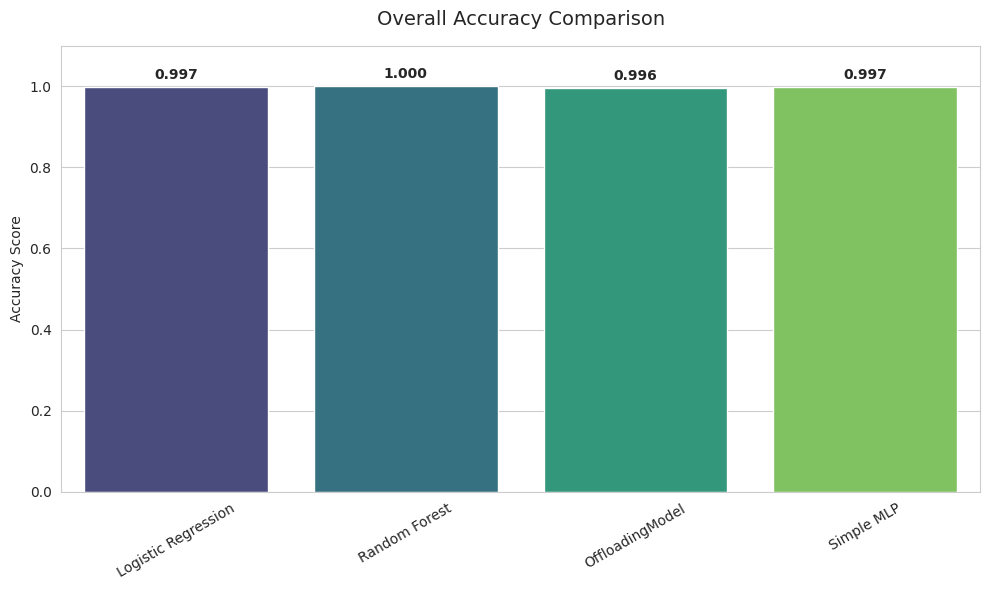

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_model_accuracy(results_dict):
    """Plots a bar chart for quick model comparison."""
    plt.figure(figsize=(10, 6))

    names = list(results_dict.keys())
    values = list(results_dict.values())

    # Create the bar plot
    ax = sns.barplot(x=names, y=values, hue=names, palette="viridis", legend=False)

    # Formatting and labeling
    plt.ylim(0, 1.1)
    plt.title("Overall Accuracy Comparison", fontsize=14, pad=15)
    plt.ylabel("Accuracy Score")
    plt.xticks(rotation=30)

    # Add text labels on top of bars for precision
    for i, v in enumerate(values):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Execute
plot_model_accuracy(results)

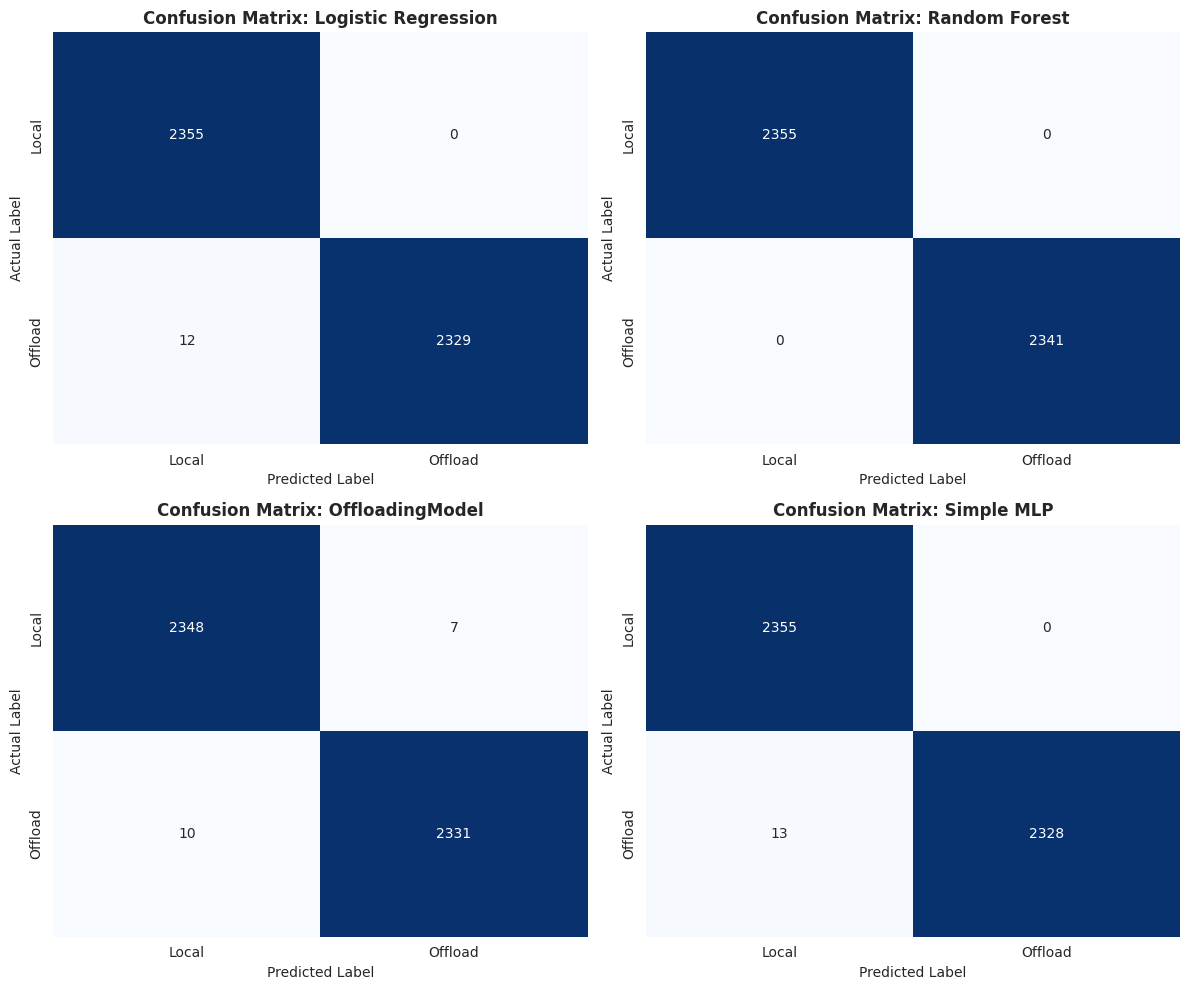

In [18]:
from sklearn.metrics import confusion_matrix
import math

def plot_confusion_grid(y_true, predictions_dict, cols=2):
    """Generates a grid of confusion matrices for error analysis."""
    num_models = len(predictions_dict)
    rows = math.ceil(num_models / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))

    # Flatten axes array for easy iteration, handle single-plot case
    axes = axes.flatten() if num_models > 1 else [axes]

    for i, (name, preds) in enumerate(predictions_dict.items()):
        cm = confusion_matrix(y_true, preds)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Local', 'Offload'],
                    yticklabels=['Local', 'Offload'],
                    cbar=False, ax=axes[i])

        axes[i].set_title(f"Confusion Matrix: {name}", fontweight='bold')
        axes[i].set_ylabel('Actual Label')
        axes[i].set_xlabel('Predicted Label')

    # Remove any unused subplots in the grid
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Execute
plot_confusion_grid(y_test, final_predictions)

In [19]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

# 1. Setup the UI components
sample_slider = widgets.IntSlider(
    value=0, min=0, max=len(X_test)-1,
    description='Sample Index:', continuous_update=False
)
output_area = widgets.Output()

def display_sample(change):
    idx = change['new']
    with output_area:
        clear_output(wait=True)

        # Get raw data for this sample
        features = X_test[idx]
        actual_label = "Offload" if y_test[idx] == 1 else "Local"

        print(f"--- Sample Data [Index {idx}] ---")
        print(f"Input Features: {features}")
        print(f"Ground Truth:   {actual_label}")
        print("-" * 30)

        # Collect predictions
        comparison_data = []
        for name, preds in final_predictions.items():
            pred_val = "Offload" if preds[idx] == 1 else "Local"
            status = "✅ Correct" if preds[idx] == y_test[idx] else "❌ Wrong"
            comparison_data.append({"Model": name, "Prediction": pred_val, "Result": status})

        # Display as a clean table
        df_comparison = pd.DataFrame(comparison_data)
        display(df_comparison)

# 2. Link the slider to the function
sample_slider.observe(display_sample, names='value')

# 3. Initial display
display(sample_slider, output_area)
# Trigger the first view
display_sample({'new': 0})

IntSlider(value=0, continuous_update=False, description='Sample Index:', max=4695)

Output()

## 5. Conclusion

This notebook demonstrated how to transform raw cluster telemetry into an intelligent decision-making engine. By utilizing the **Alibaba GenAI Cluster Trace**, we successfully trained a policy network capable of navigating the trade-offs between local GPU duty cycles and network queuing delays.

### Final Model Performance

The **Confusion Matrix** and **Classification Report** above reveal how well the model handles the two critical failure states in offloading:

* **False Offloads:** Sending a task to the cloud when the local GPU was actually free (leads to unnecessary egress costs).
* **False Locals:** Processing a task locally when the queue is backed up (leads to SLA violations and high latency).
